# Nutriscore by Vincent PREVOT and Aurélie RAOUL
# Analyse des données par pays

Après avoir traité les données et généré un fichier pré-calculé pour les pays, nous avons commencé l'analyse.

In [1]:
import pandas as pd
import numpy as np
from time import time
import folium
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd

verbose = False


## Préparation des données pour l'analyse

In [2]:
# ---------------------------------------------------------------------------------------------
# CHARGEMENT DE LA DATAFRAME
# ---------------------------------------------------------------------------------------------

t0 = time()
# Récupère le répertoire du programme
curent_path = getcwd()
# Il faut remonter d'un répertoire, car les fichiers csv sont trop gros pour GIT
# et nous avons convenu de les stocker dans le répertoire parent
file_path = curent_path.rsplit('\\', 1)[0] + "\\"
# file_path = curent_path + "\\"
file_name = "nutriscore_countries_2021-12-13-14_38_23.csv"

print("Chargement des données")
df = pd.read_csv(file_path+file_name, sep="\t", encoding="utf-8", low_memory=False)
t1 = (time() - t0)/60
print("Chargement des données ", df.shape,
      ".... in {0:.3f} minutes................................................... END".format(t1))
df.head()

Chargement des données
Chargement des données  (2067276, 14) .... in 0.061 minutes................................................... END


,index,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,pnns_groups,country_origin,country_clean,country_code,continent_code,latitude,longitude,country_alpha3,official_name
0,1219438,NaN,0,NaN,NaN,NaN,germany,Germany,DE,EU,49.932519,1.580598,DEU,Federal Republic of Germany
1,1664521,NaN,0,NaN,NaN,NaN,germany,Germany,DE,EU,49.932519,1.580598,DEU,Federal Republic of Germany
2,2000285,NaN,0,NaN,NaN,NaN,germany,Germany,DE,EU,49.932519,1.580598,DEU,Federal Republic of Germany
3,1560217,NaN,4,NaN,NaN,NaN,germany,Germany,DE,EU,49.932519,1.580598,DEU,Federal Republic of Germany
4,1228220,NaN,4,NaN,NaN,NaN,germany,Germany,DE,EU,49.932519,1.580598,DEU,Federal Republic of Germany


In [3]:
df.isna().sum()

index                    0
nutriscore_grade    428110
nova_group               0
pnns_groups_1       654340
pnns_groups_2       654340
pnns_groups         369409
country_origin           0
country_clean            2
country_code            44
continent_code      163752
latitude                61
longitude               61
country_alpha3         449
official_name           44
dtype: int64

Correction de continent_code isna en 'NA' lié à une conversion auto lors de la création du CSV.

In [4]:
# ---------------------------------------------------------------------------------------------
# TRAITEMENT DES NA
# ---------------------------------------------------------------------------------------------

def clean_df_na(df, verbose=False):
    t0 = time()
    df.loc[df['continent_code'].isna() & df['country_code'].notna(),"continent_code"]= "NA"
    t1 = time() - t0
    if verbose:
        print(df.isna().sum())
    print(
        "clean_df_na {0:.3f} secondes................................................... END".format(
            t1))


In [5]:
clean_df_na(df, True)

index                    0
nutriscore_grade    428110
nova_group               0
pnns_groups_1       654340
pnns_groups_2       654340
pnns_groups         369409
country_origin           0
country_clean            2
country_code            44
continent_code          44
latitude                61
longitude               61
country_alpha3         449
official_name           44
dtype: int64
clean_df_na 0.139 secondes................................................... END


Nous allons maintenant créer une dataframe pour représenter les produits nutriscore par pays, à travers le monde.

In [6]:
# ---------------------------------------------------------------------------------------------
# CREATION DF PAR NUTRI-SCORE
# ---------------------------------------------------------------------------------------------

df_nutri=df.copy()
df_nutri=df_nutri[['country_alpha3', 'nutriscore_grade']]
df_nutri['nutriscore_grade'].dropna(inplace=True)
df_nutri=df_nutri.groupby(['country_alpha3','nutriscore_grade']).size().reset_index()
data_nutri = df_nutri.groupby(['country_alpha3', 'nutriscore_grade'])[0].sum().unstack(fill_value=0)
data_nutri["sum"] = data_nutri.sum(axis=1)
data_nutri['country_alpha3']= data_nutri.index
data_nutri=data_nutri.sort_values(by="sum", ascending=False)
data_nutri=data_nutri.drop("sum", axis=1)
data_nutri.head()

nutriscore_grade,A,B,C,D,E,country_alpha3
country_alpha3,,,,,,
GBR,171352,143916,190212,243172,130232,GBR
FRA,91476,90306,111843,134127,84249,FRA
USA,28065,21510,30494,41332,21349,USA
ESP,6650,7255,7745,7685,3215,ESP
DEU,6104,5520,6700,6624,3748,DEU


Nous avons maintenant une dataframe utilisable pour nos analyses.

## Création des cartes du monde

Nous allons maintenant représenter proportionnellement les pays présent dans notre base de données sur une carte du monde

In [7]:
# ---------------------------------------------------------------------------------------------
# MAP WORLD NUTRI-SCORE
# ---------------------------------------------------------------------------------------------
def createWorldMap(df):
    state_data = df[['country_alpha3', 0]].groupby(by='country_alpha3').sum().sort_values(by=0, ascending=False).reset_index()
    state_data["%"] = (state_data[0] / state_data[0].sum())
    geo_data = 'world-countries.json'
    bins = list(state_data[0].quantile([0, 0.25, 0.5, 0.75, 1]))
    m = folium.Map(tiles="cartodbpositron", 
                   location=[0, 0],
                   zoom_start=2,
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)
    folium.Choropleth(
        geo_data=geo_data,
        name="choropleth",
        data=state_data,
        columns=['country_alpha3', 0],
        key_on="feature.id",
        fill_color="YlGnBu",
        bins=bins,
        fill_opacity=0.7,
        line_opacity=0.5,
        scheme='equal_interval',
        highlight=True
    ).add_to(m)
    title_html = '''
                <h3 align="center" style="font-size:20px"><b>Carte des pays disposants de produits nuitriscoré dans notre base de données.</b></h3>
                '''
    m.get_root().html.add_child(folium.Element(title_html))
    folium.LayerControl().add_to(m)
    display(m)


In [8]:
createWorldMap(df_nutri)

Cette carte nous permet de visualiser la quantité de produits nutriscorés de notre base de données à travers le monde.
Nous remarquons une plus forte présence de nutriscore sur les continent Européen, Américain et l'Océanie.

Nous décidons de nous concentrer sur les 10 premiers pays avec la plus forte présence de produits nutriscoré.

In [9]:
# ---------------------------------------------------------------------------------------------
# MAP NUTRI TOP 10
# ---------------------------------------------------------------------------------------------
def createMap(df):
    state_data = df[['country_alpha3', 0]].groupby(by='country_alpha3').sum().sort_values(by=0, ascending=False).reset_index()
    state_data["%"] = (state_data[0] / state_data[0].sum())
    state_data = state_data.sort_values(by="%", ascending=False).head(10)
    geo_data = 'world-countries.json'
    m = folium.Map(tiles="cartodbpositron", 
                   location=[0, 0],
                   zoom_start=2,
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)
    folium.Choropleth(
        geo_data=geo_data,
        name="choropleth",
        data=state_data,
        columns=['country_alpha3', "%"],
        key_on="feature.id",
        fill_color="BuPu",
        fill_opacity=0.7,
        line_opacity=0.5,
        scheme='equal_interval',
        highlight=True
    ).add_to(m)
    title_html = '''
                <h3 align="center" style="font-size:20px"><b>Carte des 10 pays les plus présent dans le fichier nutri-score.</b></h3>
                '''
    m.get_root().html.add_child(folium.Element(title_html))
    folium.LayerControl().add_to(m)
    display(m)

In [10]:
createMap(df_nutri)

Cette carte des 10 pays avec le plus grand nombre de produits "nutri-scoré", met en évidence la forte présence du  continent Européen avec 9 pays. Les Etats-Unis viennient compléter le classement. 

La grande différence de volumétrie ne permet pas d'adapter parfaitement la graduation de la légende pour mieux représenter les pays autres que France & Royaume Unis.

## Top 10 pays : présentation des grades nutriscore

Nous allons maintenant créer une série de carte pour mettre en évidence chaque grade du nutriscore pour le top 10.

In [11]:
# ---------------------------------------------------------------------------------------------
# MAP par nutri-score
# ---------------------------------------------------------------------------------------------

def createMapByNutri(data_nutri, searchNutri):
    """[summary]

    Args:
        data_nutri ([type]): [description]
        searchNutri ([type]): [description]
    """
    geo_data = 'world-countries.json'
    m = folium.Map(tiles="cartodbpositron", 
                   location=[0, 0],
                   zoom_start=2,
                   zoom_control=False,
                   scrollWheelZoom=False,
                   dragging=False)
    data_nutri = data_nutri.sort_values(
        by=searchNutri, ascending=False).head(10)
    folium.Choropleth(
        geo_data=geo_data,
        name="choropleth",
        data=data_nutri,
        columns=['country_alpha3', searchNutri],
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.5,
        legend_name=f"Nutri-score {searchNutri}",
        scheme='equal_interval',
        highlight=True
    ).add_to(m)
    title_html = '<h3 align="center" style="font-size:20px"><b>Nombre de produits pour le  nutri-score ' + searchNutri+ ' des 10 premiers pays</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    folium.LayerControl().add_to(m)
    display(m)

In [12]:
createMapByNutri(data_nutri, "A")

In [13]:
createMapByNutri(data_nutri, "B")

In [14]:
createMapByNutri(data_nutri, "C")

In [15]:
createMapByNutri(data_nutri, "D")

In [16]:
createMapByNutri(data_nutri, "E")

Ces représentations nous permettent de mettre en évidence deux pays : le Royaume-Unis et la France. 
En effet, ces pays disposent d'un volume très important de produits nutriscore en comparaison des autres pays, quelque soit le grade choisi.

## Analyse des données en graphique.

### Graphique nutriscore

Nous allons maintenant effectuer une analyse sur la répartition des grades du nutriscore par pays. 

In [17]:
def createNutriGraph(data):
    figure, axes = plt.subplots(1, 1)
    data_plot = data.transpose().reset_index()
    sns.set()
    colors = ["green", "#AACE73", "yellow", "orange", "red"]
    data_plot.set_index('nutriscore_grade').T.plot(kind='barh',
                                                    stacked=True, ax=axes, color=colors_nutri)
    figure.set_size_inches(7, 8, forward=True)
    figure.set_dpi(100)
    plt.title('Nombre de produits nutriscoré des 10 pays les plus représentés.', fontsize=14)
    plt.show()
    

colors_nutri = ["green", "#AACE73", "yellow", "orange", "red"]

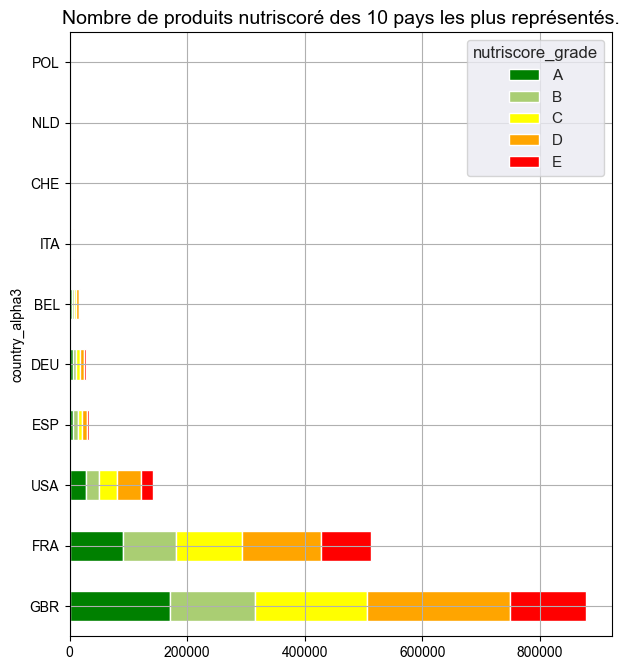

In [18]:
createNutriGraph(data_nutri.head(10))

On constate une forme d'équilibre sur les ratios des grades du nutriscore.
On note que les produits d'indice C & D représente la moitié des produits nutriscoré. Il ne semble pas nécéssaire, dans le cadre de notre analyse, de chiffrer précisement le pourcentage de présence.

De plus, on remarque que cet équilibre est vrai pour l'ensemble des pays présent dans ce top 10. Aucun pays ne se démarque par la présence d'un grade du nutriscore en particulier.

### Graphique nova groupe

Nous allons maintenant effectuer les mêmes analyses avec le nova groupe.

In [19]:
# ---------------------------------------------------------------------------------------------
# CREATION DF PAR NOVA GROUPE
# ---------------------------------------------------------------------------------------------


df_nova=df.copy()
df_nova=df_nova[['country_alpha3', 'nova_group']]
df_nova['nova_group'].dropna(inplace=True)
df_nova=df_nova.groupby(['country_alpha3','nova_group']).size().reset_index()
data_nova = df_nova.groupby(['country_alpha3', 'nova_group'])[0].sum().unstack(fill_value=0)
data_nova = data_nova.drop(0, axis=1)
data_nova["sum"] = data_nova.sum(axis=1)
data_nova['country_alpha3']= data_nova.index
data_nova=data_nova.sort_values(by="sum", ascending=False)
data_nova = data_nova.drop("sum", axis=1)

colors_nova = ["green", "yellow", "orange", "red"]

data_nova.head()

nova_group,1,2,3,4,country_alpha3
country_alpha3,,,,,
GBR,80336,1768,172832,672076,GBR
FRA,54054,1539,106011,390150,FRA
USA,11855,220,27082,111047,USA
ESP,3615,90,7590,20320,ESP
DEU,3580,80,6664,17108,DEU


<function matplotlib.pyplot.show(close=None, block=None)>

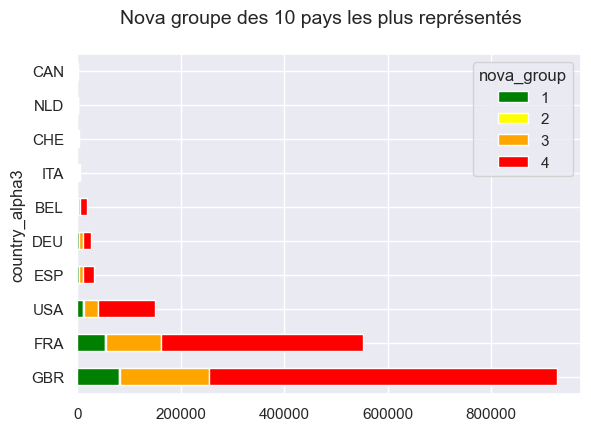

In [20]:
figure, axes = plt.subplots(1, 1)
data_nova2 = data_nova.head(10).transpose().reset_index()

sns.set()
data_nova2.set_index('nova_group').T.plot(kind='barh',
                                                stacked=True, ax=axes, color=colors_nova)
figure.set_size_inches(6.5, 4.5, forward=True)
figure.set_dpi(100)
fig = plt.gcf()
fig.suptitle('Nova groupe des 10 pays les plus représentés', fontsize=14)

plt.show

Cette fois, une tendance se dessine : les nova group 3 & 4 sont fortement représentés sur l'ensemble des produits notés de ce top 10. Il s'agit donc de produits de faible qualité, ultra transformés.

### Comparaison des graphiques nutriscore et nova groupe

Pour comparer les graphiques du nutriscore et du nova groupe , nous allons les mettre côte à cote pour une meilleur visibilité.

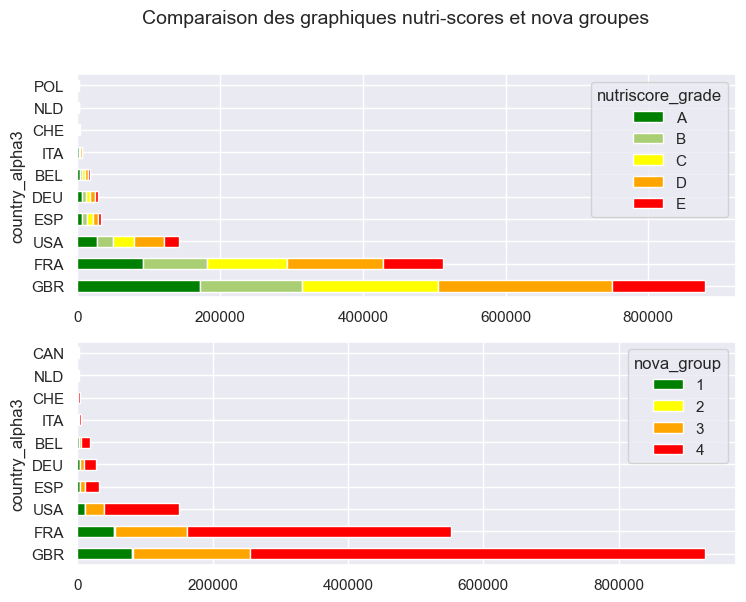

In [21]:
# ---------------------------------------------------------------------------------------------
# Comparaison nutri-score et nova-groupe
# ---------------------------------------------------------------------------------------------

# Création du graphique nutriscore
figure, axes = plt.subplots(2, 1)
data_nutri2 = data_nutri.head(10).transpose().reset_index()
data_nutri2 = data_nutri2.drop(5, axis=0)
sns.set()
figure.suptitle('Comparaison des graphiques nutri-scores et nova groupes', fontsize=14)
data_nutri2.set_index('nutriscore_grade').T.plot(kind='barh',
                                                stacked=True, ax=axes[0], color=colors_nutri)
figure.set_size_inches(7.5, 4.5, forward=True)
figure.set_dpi(100)

# Création du graphique nova groupe
data_nova2 = data_nova.head(10).transpose().reset_index()
sns.set()
data_nova2.set_index('nova_group').T.plot(kind='barh',
                                                stacked=True, ax=axes[1], color=colors_nova)
figure.set_size_inches(8.5, 6.5, forward=True)
figure.set_dpi(100)

plt.show()

La comparaison entre nos deux graphiques, du nutriscore et du nova groupe, nous permet de constater la grande différence de résultats.

Par exemple, le nova groupe 4 correspond aux nutriscore C, D & E. 
A l'inverse, le nutriscore A correpond au nova groupe 1 et également à une partie du nova groupe 2.

Ces deux classifications confirme donc leur différences de critères.
Le nutriscore et le nova groupe sont complémentaires, mais ne peuvent être comparer.